<a href="https://colab.research.google.com/github/julesripoll/contrastive-learning/blob/lea_branch/Projet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/axelcarlier/projsemisup.git
path = "./projsemisup/"

Cloning into 'projsemisup'...
remote: Enumerating objects: 10798, done.
remote: Counting objects: 100% (10798/10798), done.
remote: Compressing objects: 100% (10798/10798), done.
remote: Total 10798 (delta 0), reused 10798 (delta 0), pack-reused 0
Receiving objects: 100% (10798/10798), 328.98 MiB | 13.76 MiB/s, done.
Checking out files: 100% (11563/11563), done.


In [ ]:
import csv
CLASSES = []
with open(path + 'selected_classes.csv', newline='') as csvfile:
	filereader = csv.reader(csvfile, delimiter=',', quotechar='"')
	for row in filereader:
		CLASSES.append(row[0])

print(CLASSES)

['red fox', 'gray wolf', 'snail', 'lizard', 'spider', 'turtle', 'hippopotamus', 'mosquito', 'crocodile', 'oyster', 'ant', 'american black bear', 'grizzly bear', 'chicken', 'beluga whale', 'humpback whale', 'tiger shark', 'dolphin', 'eagle', 'deer', 'parrot', 'falcon', 'snake', 'king penguin', 'giant panda', 'giraffe', 'donkey', 'sheep', 'salamander', 'wombat', 'bee', 'bat', 'rabbit', 'rooster', 'guinea pig', 'pig', 'goats', 'koala', 'gorilla', 'lion', 'tiger', 'leopard', 'jaguar', 'lynx', 'sea lion', 'great white shark', 'dog', 'elephant', 'cat', 'owl', 'squirrel', 'duck', 'frog', 'ibis', 'dairy cow', 'bull', 'horse', 'caterpillar', 'butterfly', 'chimpanzee', 'orangutan', 'kangaroo', 'camel', 'mouse', 'turkey', 'rhinoceros', 'baboon', 'moose', 'komodo dragon', 'okapi', 'antelope', 'ostrich', 'bison', 'water buffalo', 'beaver', 'hyena', 'swan', 'flamingo', 'hedgehog', 'raccoon', 'heron', 'lama', 'sea otter', 'macaque', 'peafowl', 'pelican', 'warthog', 'polecat', 'killer whale', 'wallaby

In [ ]:
IMAGE_SIZE = 64

In [ ]:
import os
import PIL
from PIL import Image
import numpy as np

def load_semisup_data(path, classes, image_size=64):

  file_path_lab = os.listdir(path + 'Lab/')
  nb_lab = 475
  # Initialise les structures de données
  x_lab = np.zeros((nb_lab, image_size, image_size, 3))
  y_lab = np.zeros((nb_lab, 1))
  i = 0
  for c in file_path_lab:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Lab/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Lab/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)
      # Remplissage de la variable x
      x_lab[i] = np.asarray(img)
      y_lab[i] = class_label
      i = i + 1


  file_path_test = os.listdir(path + 'Test/')
  nb_test = 2850
  # Initialise les structures de données
  x_test = np.zeros((nb_test, image_size, image_size, 3))
  y_test = np.zeros((nb_test, 1))
  i = 0
  for c in file_path_test:

    class_label = classes.index(c)
    list_images = os.listdir(path + 'Test/' + c + '/')

    for img_name in list_images:
      # Lecture de l'image
      img = Image.open(path + 'Test/' + c + '/' + img_name)
      # Mise à l'échelle de l'image
      img = img.resize((image_size,image_size), Image.ANTIALIAS)
      img = img.convert('RGB')
      # Remplissage de la variable x
      x_test[i] = np.asarray(img)
      y_test[i] = class_label
      i = i + 1


  file_path_unlab = os.listdir(path + 'Unlab/')
  nb_unlab = 8237
  # Initialise les structures de données
  x_unlab = np.zeros((nb_unlab, image_size, image_size, 3))

  i = 0
  for img_name in file_path_unlab:
    # Lecture de l'image
    img = Image.open(path + 'Unlab/' + img_name)
    # Mise à l'échelle de l'image
    img = img.resize((image_size,image_size), Image.ANTIALIAS)
    img = img.convert('RGB')
    # Remplissage de la variable x
    x_unlab[i] = np.asarray(img)
    i = i + 1

  return x_lab, y_lab, x_unlab, x_test, y_test


x_lab, y_lab, x_unlab, x_test, y_test = load_semisup_data(path, CLASSES, image_size=IMAGE_SIZE)




In [ ]:
print(x_lab.shape, y_lab.shape)
print(x_test.shape, y_test.shape)

(475, 64, 64, 3) (475, 1)
(2850, 64, 64, 3) (2850, 1)


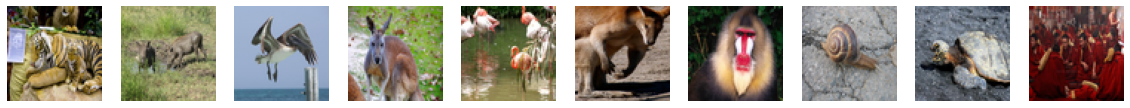

In [ ]:
import random as rd
import matplotlib.pyplot as plt
n = 10
idx = [rd.randint(0, x_test.shape[0]) for _ in range(0, n)]

plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[idx[i]].reshape(64, 64,3)/255.)
    ax.grid(False)
    plt.axis('off')
plt.show()

In [ ]:
def plot_training_analysis():
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

model = Sequential()

model.add(Conv2D(64,(3,3),input_shape=(IMAGE_SIZE,IMAGE_SIZE,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dense(95,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 256)        0

In [ ]:
import tensorflow as tf
import albumentations as A
import cv2

def my_transformer(img):
  transform = A.Compose([A.transforms.RandomCrop(p=0.8), 
                         A.RandomBrightnessContrast(p=0.8),
                         A.HorizontalFlip(p=0.5),
                         A.RandomRotate90(p=0.8)])

  transformed=transform(image=img)
  transformed_img=transformed['image']
  return transformed_img

from keras.preprocessing.image import ImageDataGenerator
train_datagen=ImageDataGenerator(preprocessing_function=my_transformer)
train_generator=train_datagen.flow( x_lab,y_lab, batch_size=10)


In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])
#history = model.fit(x_lab, y_lab, validation_data=(x_test, y_test), epochs=30, batch_size=10)

history = model.fit(train_datagen.flow(x_lab, y_lab, batch_size=10),validation_data=train_datagen.flow(x_test,y_test, batch_size=10),steps_per_epoch=int(len(x_lab)/10), epochs=30)

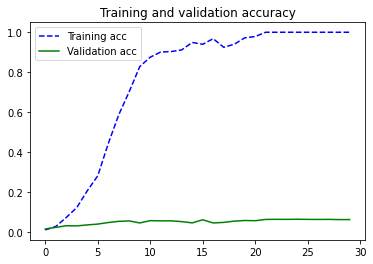

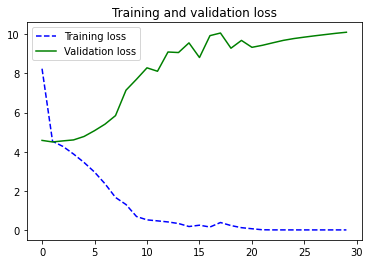

In [ ]:
plot_training_analysis()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
#cosine similarity (in the paper -> sim(z_i,z_j)) utile pour la loss


In [ ]:
def contrastive_loss(xi, xj,  tau=1, normalize=False):
        ''' this loss is the modified torch implementation by M Diephuis here: https://github.com/mdiephuis/SimCLR/
        the inputs:
        xi, xj: image features extracted from a batch of images 2N, composed of N matching paints
        tau: temperature parameter
        normalize: normalize or not. seem to not be very useful, so better to try without.
        '''

        x = tf.keras.backend.concatenate((xi, xj), axis=0)

        sim_mat = tf.keras.backend.dot(x, tf.keras.backend.transpose(x))

        if normalize:
            sim_mat_denom = tf.keras.backend.dot(tf.keras.backend.l2_normalize(x, axis=1).unsqueeze(1), tf.keras.backend.l2_normalize(x, axis=1).unsqueeze(1).T)
            sim_mat = sim_mat / sim_mat_denom.clamp(min=1e-16)

        sim_mat = tf.keras.backend.exp(sim_mat /tau)

        if normalize:
            sim_mat_denom = tf.keras.backend.l2_normalize(xi, dim=1) * tf.keras.backend.l2_normalize(xj, axis=1)
            sim_match = tf.keras.backend.exp(tf.keras.backend.sum(xi * xj, axis=-1) / sim_mat_denom / tau)
        else:
            sim_match = tf.keras.backend.exp(tf.keras.backend.sum(xi * xj, axis=-1) / tau)

        sim_match = tf.keras.backend.concatenate((sim_match, sim_match), axis=0)

        norm_sum = tf.keras.backend.exp(tf.keras.backend.ones(tf.keras.backend.shape(x)[0]) / tau)

        return tf.math.reduce_mean(-tf.keras.backend.log(sim_match / (tf.keras.backend.sum(sim_mat, axis=-1) - norm_sum)), name='contrastive_loss')

In [3]:
"""Layer-wise Adaptive Rate Scaling optimizer for large-batch training."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.python.framework import ops
from tensorflow.python.platform import tf_logging
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import control_flow_ops
from tensorflow.python.ops import clip_ops
from tensorflow.python.ops import linalg_ops
from tensorflow.python.ops import logging_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import state_ops
from tensorflow.python.ops import variables
from tensorflow.python.training import optimizer
from tensorflow.python.training import training_ops
from tensorflow.python.training import training_util

class LARSOptimizer(optimizer.Optimizer):
  """Layer-wise Adaptive Rate Scaling for large batch training.

  Introduced by "Large Batch Training of Convolutional Networks" by Y. You,
  I. Gitman, and B. Ginsburg. (https://arxiv.org/abs/1708.03888)

  Implements the LARS learning rate scheme presented in the paper above. This
  optimizer is useful when scaling the batch size to up to 32K without
  significant performance degradation. It is recommended to use the optimizer
  in conjunction with:
      - Gradual learning rate warm-up
      - Linear learning rate scaling
      - Poly rule learning rate decay
  """

  def __init__(self,
               learning_rate,           # use linear scaling rule
               momentum=0.9,            # suggested by paper
               weight_decay=0.0001,     # suggested by paper
               eeta = 0.001,
               epsilon = 1e-5,
               name="LARSOptimizer"):
    """Construct a new LARS Optimizer.

    Args:
      learning_rate: A `Tensor` or floating point value. The base learning rate.
      momentum: A floating point value. Momentum hyperparameter.
      weight_decay: A floating point value. Weight decay hyperparameter.
      name: Optional name prefix for variables and ops created by LARSOptimizer.

    Raises:
      ValueError: If a hyperparameter is set to a non-sensical value.
    """
    if momentum < 0.0:
      raise ValueError(
          "momentum should be positive: %s" % momentum)
    if weight_decay < 0.0:
      raise ValueError(
          "weight_decay should be positive: %s" % weight_decay)
    super(LARSOptimizer, self).__init__(use_locking=False, name=name)

    self._learning_rate = learning_rate
    self._momentum = momentum
    self._weight_decay = weight_decay
    self._eeta = eeta
    self._epsilon = epsilon
    self._name = name

  def _create_slots(self, var_list):
    for v in var_list:
      self._zeros_slot(v, "momentum", self._name)

  def _apply_dense(self, grad, var):
    scaled_lr = self._learning_rate
    decayed_grad = grad
    tf_logging.info("LARS: apply dense: %s", var.name)
    if 'batch_normalization' not in var.name and 'bias' not in var.name:
      tf_logging.info("LARS: apply dense, decay: %s", var.name)
      w_norm = linalg_ops.norm(var, ord=2)
      g_norm = linalg_ops.norm(grad, ord=2)
      trust_ratio = array_ops.where(
          math_ops.greater(w_norm, 0),
          array_ops.where(
              math_ops.greater(g_norm, 0),
              (self._eeta * w_norm /
               (g_norm + self._weight_decay * w_norm + self._epsilon)),
              1.0),
          1.0)
      trust_ratio = clip_ops.clip_by_value(trust_ratio, 0.0, 50)
      scaled_lr = self._learning_rate * trust_ratio
      decayed_grad = grad  + self._weight_decay * var

    decayed_grad = clip_ops.clip_by_value(decayed_grad, -10.0, 10.0)
    mom = self.get_slot(var, "momentum")
    return training_ops.apply_momentum(
        var, mom,
        scaled_lr,
        decayed_grad,
        self._momentum,
        use_locking=False,
        use_nesterov=False)

  def _resource_apply_dense(self, grad, var):
    scaled_lr = self._learning_rate
    decayed_grad = grad
    tf_logging.info("LARS: resouce apply dense: %s", var.name)
    w_norm = linalg_ops.norm(var, ord=2)
    g_norm = linalg_ops.norm(grad, ord=2)
    if 'batch_normalization' not in var.name and 'bias' not in var.name:
      tf_logging.info("LARS: apply dense, decay: %s", var.name)
      trust_ratio = array_ops.where(
          math_ops.greater(w_norm, 0),
          array_ops.where(
              math_ops.greater(g_norm, 0),
              (self._eeta * w_norm /
               (g_norm + self._weight_decay * w_norm + self._epsilon)),
              1.0),
          1.0)
      trust_ratio = clip_ops.clip_by_value(trust_ratio, 0.0, 50)
      scaled_lr = self._learning_rate * trust_ratio
      decayed_grad = grad + self._weight_decay * var

    decayed_grad = clip_ops.clip_by_value(decayed_grad, -10.0, 10.0)
    mom = self.get_slot(var, "momentum")
    return training_ops.resource_apply_momentum(
        var.handle, mom.handle,
        scaled_lr,
        decayed_grad,
        self._momentum,
        use_locking=False,
        use_nesterov=False)

In [4]:
from tensorflow import keras

#boucle custom training
batch_size=10
epochs=10
history=[]

# Instanciation d'un optimiseur et d'une fonction de coût.
optimizer = LARSOptimizer(learning_rate=1e-3)
loss_fn = contrastive_loss

# Préparation des métriques pour le suivi de la performance du modèle.
test_acc_metric = keras.metrics.Sparse_CategoricalAccuracy()

steps_per_epoch = np.floor(x_lab.shape[0]/batch_size)

for epoch in range(epochs):
  cum_loss_value = 0

  for step in range(steps_per_epoch):
    # Sélection des données du prochain batch
    x_batch = x_unlab[step*batch_size: (step+1)*batch_size]
    ##y_batch = y_lab[step*batch_size: (step+1)*batch_size]

    # Etape nécessaire pour comparer y_batch à la sortie du réseau
   ## y_batch = np.expand_dims(y_batch, 1)

    # Les opérations effectuées par le modèle dans ce bloc sont suivies et permettront
    # la différentiation automatique.
    with tf.GradientTape() as tape:

      # Application du réseau aux données d'entrée
      z_pred1 = model(x_batch, training=True) #avec dataaugm1
      z_pred2 = model(x_batch, training=True) # avec dataaugm2
      # Calcul de la fonction de perte sur ce batch

      loss_value = loss_fn(z_pred1, z_pred2)
      history.append(loss_value)
      # Calcul des gradients par différentiation automatique
      grads = tape.gradient(loss_value, model.trainable_weights)

      # Réalisation d'une itération de la descente de gradient (mise à jour des paramètres du réseau)
      optimizer.apply_gradients(zip(grads, model.trainable_weights))

      

      cum_loss_value = cum_loss_value + loss_value

  # Calcul de la précision à la fin de l'epoch
  if epoch %20 ==0 :
    predictor=create_model() ####### TO DO #######
    labels_pred=predictor.predict(x_lab)
    y_true=np.expand_dims(y_lab, 1)
    accuracy=test_acc_metric(y_true, labels_pred)
    print("Epoch %4d : Loss : %.4f,  Test Acc : %.4f" % (epoch, float(cum_loss_value/steps_per_epoch), float(accuracy)))
  else :
    print("Epoch %4d : Loss : %.4f" % (epoch, float(cum_loss_value/steps_per_epoch)))


NameError: ignored